In [2]:
import numpy as np
import os
import torch
from sklearn.datasets import fetch_lfw_people
import torchvision.models as models
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split


Fetching Dataset

In [3]:
# Fetch LFW dataset with minimum faces per person = 40
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# Extracting data and target labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
# df = np.genfromtxt('./lfw_people.csv',delimiter=',')
# X = df[:, :-1]
# y = df[:, -1]
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

# Print dataset statistics
print("Number of samples: %d" % n_samples)
print("Number of features: %d" % n_features)
print("Number of classes: %d" % n_classes)

Number of samples: 1288
Number of features: 1850
Number of classes: 7


Restructuring Image Pixel Values

In [22]:
img = X[0].reshape((lfw_people.images.shape[1],lfw_people.images.shape[2]))
print(img)

[[0.9973857  0.99607843 0.9921568  ... 0.29803923 0.24836601 0.20653595]
 [0.9973857  0.9921569  0.9908497  ... 0.30588236 0.2535948  0.21568628]
 [0.96078426 0.93071896 0.8679738  ... 0.2875817  0.24183007 0.21568628]
 ...
 [0.34509805 0.26143792 0.17385621 ... 0.4248366  0.40261438 0.39084968]
 [0.30980393 0.23398693 0.17124183 ... 0.39869282 0.4013072  0.3764706 ]
 [0.28366014 0.2248366  0.18039216 ... 0.38169935 0.38823533 0.3803922 ]]


[[254 254 252 ...  76  63  52]
 [254 253 252 ...  78  64  55]
 [244 237 221 ...  73  61  55]
 ...
 [ 88  66  44 ... 108 102  99]
 [ 79  59  43 ... 101 102  96]
 [ 72  57  46 ...  97  99  97]]
Hugo Chavez


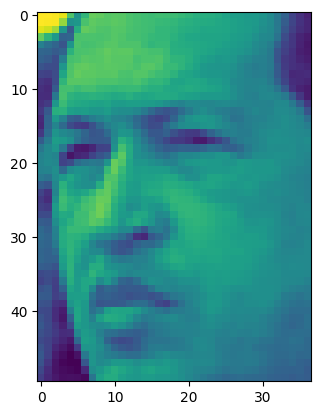

In [4]:
#Restructuring pixel values to have value between 0 to 255
img = (img * 255).astype(np.uint8)
print(img)
plt.imshow(img)
print(target_names[5])

Model Building

In [8]:
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.8MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Feature Extraction Function

In [10]:
def extract_features(image_arrays, model):
    # Load and preprocess the images
    preprocessed_images = []
    for image_array in image_arrays:
        img = image_array.reshape((lfw_people.images.shape[1],lfw_people.images.shape[2]))
        img = (img * 255).astype(np.uint8)
        image = Image.fromarray(img).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
        ])
        image = preprocess(image)
        preprocessed_images.append(image)

    # Stack the preprocessed images to create a batch tensor
    batch_tensor = torch.stack(preprocessed_images)

    # Extract features
    with torch.no_grad():
        features = model(batch_tensor)

    return features

# img = X[0].reshape((lfw_people.images.shape[1],lfw_people.images.shape[2]))
# img = (img * 255).astype(np.uint8)

In [11]:
print(X.shape)

(1288, 1850)


Batch division

In [12]:
batch_size = 28

X_train_batches = []
y_train_batches = []

for i in range(int(X.shape[0]/batch_size)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch1 = X[start_idx:end_idx]
    batch2 = X[start_idx:end_idx]
    X_train_batches.append(batch1)
    y_train_batches.append(batch2)

X_batches = np.array(X_train_batches)
y_batches = np.array(y_train_batches)

In [23]:
print(X_batches.shape)

(46, 28, 1850)


Feature Extraction

In [14]:
output = []
for i in range(X_batches.shape[0]):
  print('Iteration: ', i, '\n')
  features = extract_features(X_batches[i], resnet)
  output.append(features)

Iteration:  0 

Iteration:  1 

Iteration:  2 

Iteration:  3 

Iteration:  4 

Iteration:  5 

Iteration:  6 

Iteration:  7 

Iteration:  8 

Iteration:  9 

Iteration:  10 

Iteration:  11 

Iteration:  12 

Iteration:  13 

Iteration:  14 

Iteration:  15 

Iteration:  16 

Iteration:  17 

Iteration:  18 

Iteration:  19 

Iteration:  20 

Iteration:  21 

Iteration:  22 

Iteration:  23 

Iteration:  24 

Iteration:  25 

Iteration:  26 

Iteration:  27 

Iteration:  28 

Iteration:  29 

Iteration:  30 

Iteration:  31 

Iteration:  32 

Iteration:  33 

Iteration:  34 

Iteration:  35 

Iteration:  36 

Iteration:  37 

Iteration:  38 

Iteration:  39 

Iteration:  40 

Iteration:  41 

Iteration:  42 

Iteration:  43 

Iteration:  44 

Iteration:  45 



In [ ]:
output = np.array(output) #Conversion of list to array
output = output.squeeze(3).squeeze(3) #Squeezing last two dimensions to make it a 3-D array
output = output.reshape(-1,2048) #Reshaping into a 2-D array
torch.save(output, 'extracted_features.pt') #Saving the extracted features in a pt file so that it can be used later

Train-Test Split

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(output, y, test_size=0.2, random_state=0)

Creating a train-test split of original data

In [30]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, y, test_size=0.2, random_state=0)

Finding best SVM parameters

1. SVM Kernel = RBF

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.417 total time=   1.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.413 total time=   1.7s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.413 total time=   1.6s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.413 total time=   1.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.413 total time=   1.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.417 total time=   3.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.413 total time=   2.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.413 total time=   1.6s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.413 total time=   1.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.413 total time=   1.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.544 total time=   1.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

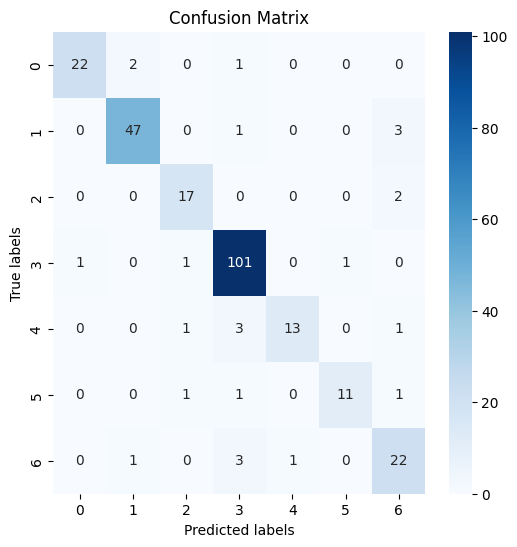

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import seaborn as sns

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, Y_train)
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("RBF Kernel model Accuracy:")
print(accuracy_score(Y_test, y_pred))

# Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

2. SVM Kernel = Polynomial

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ....degree=2, gamma=1, kernel=poly;, score=0.893 total time=   0.6s
[CV 2/5] END ....degree=2, gamma=1, kernel=poly;, score=0.913 total time=   0.6s
[CV 3/5] END ....degree=2, gamma=1, kernel=poly;, score=0.913 total time=   0.7s
[CV 4/5] END ....degree=2, gamma=1, kernel=poly;, score=0.888 total time=   0.6s
[CV 5/5] END ....degree=2, gamma=1, kernel=poly;, score=0.922 total time=   0.7s
[CV 1/5] END ..degree=2, gamma=0.1, kernel=poly;, score=0.893 total time=   0.4s
[CV 2/5] END ..degree=2, gamma=0.1, kernel=poly;, score=0.913 total time=   0.4s
[CV 3/5] END ..degree=2, gamma=0.1, kernel=poly;, score=0.913 total time=   0.4s
[CV 4/5] END ..degree=2, gamma=0.1, kernel=poly;, score=0.888 total time=   0.6s
[CV 5/5] END ..degree=2, gamma=0.1, kernel=poly;, score=0.922 total time=   0.5s
[CV 1/5] END .degree=2, gamma=0.01, kernel=poly;, score=0.888 total time=   0.5s
[CV 2/5] END .degree=2, gamma=0.01, kernel=poly;

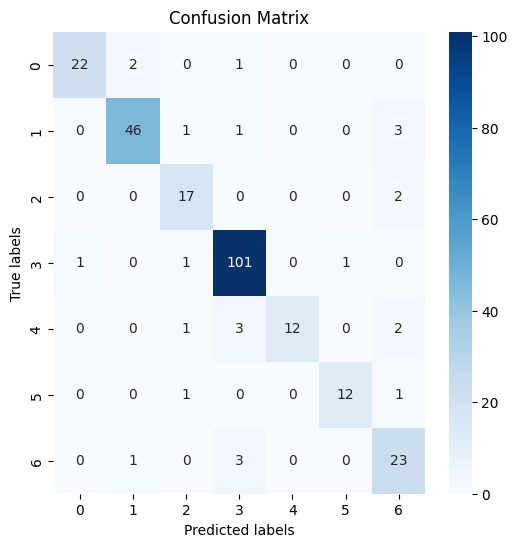

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import seaborn as sns

# defining parameter range
param_grid = {'degree': [2,3,4],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, Y_train)
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Polynomial Kernel model Accuracy:")
print(accuracy_score(Y_test, y_pred))

# Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

3. SVM Kernel = Linear

Linear Kernel model Accuracy:
0.9069767441860465


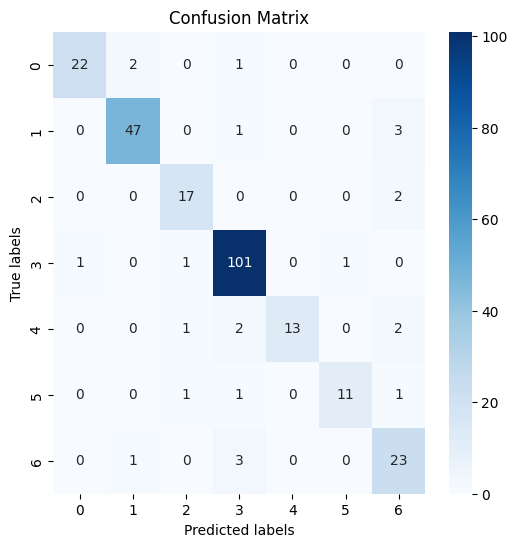

In [43]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, Y_train)
y_pred = svm_linear.predict(X_test)
print("Linear Kernel model Accuracy:")
print(accuracy_score(Y_test, y_pred))

# Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()